# DS-SF-23 | Codealong 16 | Exploring Rossmann Drug Store Sales Data (cont.) | Answer Key

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf

pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

%matplotlib inline
plt.style.use('ggplot')

To explore time series models, we will continue to use the Rossmann sales data.

This dataset has sales data for every Rossmann store for a 3-year period and indicators for holidays and basic store information.

In the last class, we saw that we could plot the sales data at a particular store to identify how the sales changed over time.

We also computed autocorrelation for the data at varying lag periods.  This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day, week, or month.

In [8]:
df = pd.read_csv(os.path.join('..', 'datasets', 'rossmann.csv'), skipinitialspace = True, low_memory = False)

df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace = True)

df.Sales = df.Sales.astype(float)

Again, let's focus on the first store.

In [9]:
df = df[df.Store == 1]

In [10]:
df

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263.0,555,1,1,0,1
2015-07-30,1,4,5020.0,546,1,1,0,1
2015-07-29,1,3,4782.0,523,1,1,0,1
2015-07-28,1,2,5011.0,560,1,1,0,1
2015-07-27,1,1,6102.0,612,1,1,0,1
...,...,...,...,...,...,...,...,...
2013-01-05,1,6,4997.0,635,1,0,0,1
2013-01-04,1,5,4486.0,619,1,0,0,1
2013-01-03,1,4,4327.0,578,1,0,0,1


Plot the sales over time.

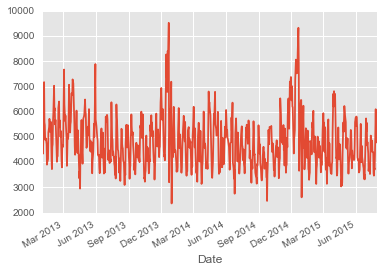

In [11]:
df[df.Open == 1].Sales.plot()

## Activity | Compute the autocorrelation of Sales in Store 1 for lag 1 and 2.

In [12]:
df.Sales.autocorr(lag = 1)

-0.12732514339140216

In [7]:
df.Sales.autocorr(lag = 2)

-0.034787155707946972

## Activity | Will we be able to use a predictive model, particularly an autoregressive one?

Answer: We do see some minimal correlation in time, implying an AR model can be useful.

An easier way to diagnose this may be to plot many autocorrelations at once.

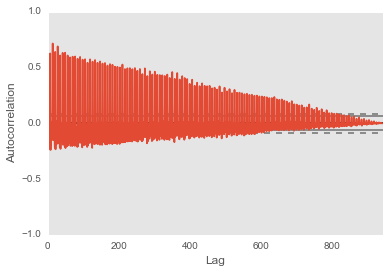

In [8]:
pd.tools.plotting.autocorrelation_plot(df.Sales)

This shows a typical pattern of an autocorrelation plot, that it should decrease to 0 as lag increases.  However, it's hard to observe exactly what the values are.

## `statsmodels` and autocorrelation plots

`statsmodels` has a better autocorrelation plot that allows us to look at fixed number of lag values.

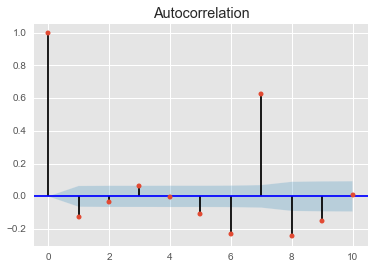

In [9]:
plot = plot_acf(df.Sales, lags = 10)

Here we observe autocorrelation at 10 lag values.  1 and 2 are what we saw before.  This implies a small but limited impact based on the last few values.  An autoregressive model might be useful.  We also see a larger spike at 7 (the seventh day in the week).

If we observed a handful of random distributed spikes, a moving average model would be useful.

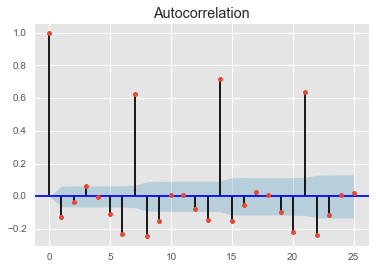

In [13]:
plot = plot_acf(df.Sales, lags = 25)

Expanding the window to 25 days, we can see that the random spikes occur regularly at 7 days.  What does this mean?

## `statsmodels` and `AR`, `MA`, `ARMA`, and `ARIMA` models

In this class, we will use `statsmodels` to code AR, MA, ARMA, and ARIMA models.

To explore `AR`, `MA`, and `ARMA` models, we will use `sm.tsa.arima_model.ARMA`.  (http://statsmodels.sourceforge.net/0.6.0/generated/statsmodels.tsa.arima_model.ARMA.html)

Remember, an `ARMA` model is a combination of autoregressive and moving average models.

We can train an `AR` model by turning off the MA component (`q = 0`).

In [14]:
model = sm.tsa.arima_model.ARMA(df[df.Open == 1].Sales, (1, 0)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Tue, 28 Jun 2016   AIC                          12540.651
Time:                        19:54:35   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        4762.6173     82.986     57.391      0.000      4599.969  4925.266
ar.L1.Sales     0.6822      0.026     26.122      0.000         0.631     0.733
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4659           +0.0000j            1.4659            0.0000
-----------------------------------------------------------------------------
"""

By passing `(1, 0)` in the second argument, we are fitting an ARMA model with `p = 1`, `q = 0`.  This is the same as an `AR(1)` model.

In this `AR(1)` model, we learn an intercept (or base sales) value.

Additionally, we learn a coefficient that tells us how to include the latest sales value.

In this case, we add an intercept of ~4800 to 0.68 times the previous month's sales.  Note that the coefficient is not equal to the lag 1 autocorrelation.  This implies the data is __not__ stationary.

We can learn an `AR(2)` model, which regresses each sales value on the last two.

In [15]:
model = sm.tsa.arima_model.ARMA(df.Sales, (2, 0)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:                     ARMA(2, 0)   Log Likelihood               -8494.475
Method:                       css-mle   S.D. of innovations           1995.279
Date:                Tue, 28 Jun 2016   AIC                          16996.950
Time:                        19:54:36   BIC                          17016.342
Sample:                    07-31-2015   HQIC                         17004.342
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        3946.0779     54.837     71.960      0.000      3838.600  4053.556
ar.L1.Sales    -0.1340      0.033     -4.112      0.000        -0.198    -0.070
ar.L2.Sales    -0.0517      0.033     -1.588      0.113        -0.116     0.012
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2951           -4.2011j            4.3962           -0.2976
AR.2           -1.2951           +4.2011j            4.3962            0.2976
-----------------------------------------------------------------------------
"""

In this case, we learn two coefficients, which tell us the effect of the last two sales values on the current sales.  While this model may perform better, it may be more difficult to interpret.

## Residuals

To start to diagnose the model, we want to look at residuals.

1. What are residuals?
1. In linear regression, what did we expect of residuals?

- Residuals are the errors of the model or how off our predictions are
- Ideally, we want randomly distributed errors that are small
- If the errors are large, our model does not perform well
- If the errors have a pattern, particularly over time, we may have overlooked something in the model or have periods of time that are different than the rest of the dataset

We can use `statsmodels` to plot the residuals.

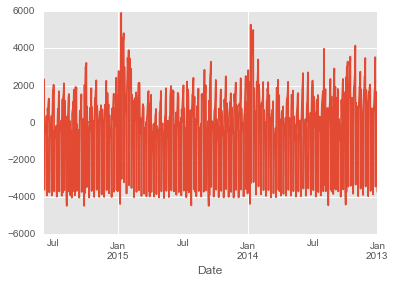

In [16]:
model.resid.plot()

Our model considers a short period of time, so it does not take into account the longer seasonal pattern.  We can also plot the autocorrelations of the residuals.  In an ideal world, these would all be near 0 and appear random.

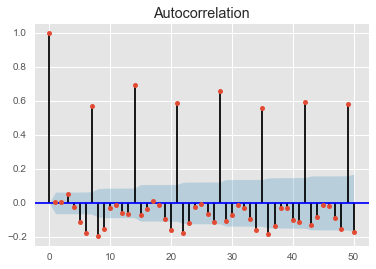

In [17]:
plot = plot_acf(model.resid, lags = 50)

This plot shows a problem: the errors are increasing and decreasing every week in a clear pattern.  We may need to expand our model.  To expand this `AR` model to an `ARMA` model, we can include the moving average component as well.

In [18]:
model = sm.tsa.arima_model.ARMA(df.Sales.astype(float), (1, 1)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:                     ARMA(1, 1)   Log Likelihood               -8495.049
Method:                       css-mle   S.D. of innovations           1996.498
Date:                Tue, 28 Jun 2016   AIC                          16998.098
Time:                        19:54:40   BIC                          17017.490
Sample:                    07-31-2015   HQIC                         17005.489
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        3945.7049     55.525     71.061      0.000      3836.877  4054.533
ar.L1.Sales     0.0884      0.203      0.435      0.664        -0.310     0.487
ma.L1.Sales    -0.2220      0.198     -1.120      0.263        -0.611     0.167
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           11.3090           +0.0000j           11.3090            0.0000
MA.1            4.5035           +0.0000j            4.5035            0.0000
-----------------------------------------------------------------------------
"""

Now we learn two coefficients, one for the `AR(1)` component and one for the `MA(1)` component.

## Activity

1. Take a moment to look at the coefficients of our new model
1. Offer an interpretation of this model

Answer:

- Remember that this is an `AR(1) + MA(1)` model.  The AR coefficient represents dependency on the last value and the MA component represents any spikes independent of the last value
- The coefficients here are 0.69 for the AR component and -0.03 for the MA component
- The AR coefficient is the same as before (decreasing values)
- The MA component is fairly small (which we should have expected from the autocorrelation plots)

We can also use statsmodels to fit `ARIMA` models.  Let's start by using `ARIMA(1, 0, 1)` to fit an `ARMA(1, 1)` model.

In [28]:
# Run ARMA regression (since q = 0)
model = sm.tsa.arima_model.ARIMA(df.Sales, (1, 0, 1)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  942
Model:                     ARMA(1, 1)   Log Likelihood               -8495.049
Method:                       css-mle   S.D. of innovations           1996.498
Date:                Tue, 28 Jun 2016   AIC                          16998.098
Time:                        19:56:22   BIC                          17017.490
Sample:                    07-31-2015   HQIC                         17005.489
                         - 01-01-2013                                         
===============================================================================
                  coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const        3945.7049     55.525     71.061      0.000      3836.877  4054.533
ar.L1.Sales     0.0884      0.203      0.435      0.664        -0.310     0.487
ma.L1.Sales    -0.2220      0.198     -1.120      0.263        -0.611     0.167
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           11.3090           +0.0000j           11.3090            0.0000
MA.1            4.5035           +0.0000j            4.5035            0.0000
-----------------------------------------------------------------------------
"""

We can see that this model is the same as our previous ARMA model.  We can also fit a true ARIMA model to predict the difference of the series.

In [29]:
model = sm.tsa.arima_model.ARIMA(df[df.Open == 1].Sales, (1, 1, 1)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6261.011
Method:                       css-mle   S.D. of innovations            738.624
Date:                Tue, 28 Jun 2016   AIC                          12530.022
Time:                        19:56:27   BIC                          12548.659
Sample:                    07-30-2015   HQIC                         12537.190
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.5108      0.364      1.405      0.160        -0.202     1.223
ar.L1.D.Sales     0.6801      0.026     25.801      0.000         0.628     0.732
ma.L1.D.Sales    -1.0000      0.004   -240.411      0.000        -1.008    -0.992
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4703           +0.0000j            1.4703            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

We can remove the MA component since it does not appear to be useful.

In [38]:
# Regress with p = 1 and q = 1
model = sm.tsa.arima_model.ARIMA(df[df.Open == 1].Sales, (1, 1, 0)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -6313.616
Method:                       css-mle   S.D. of innovations            792.680
Date:                Tue, 28 Jun 2016   AIC                          12633.233
Time:                        20:04:53   BIC                          12647.211
Sample:                    07-30-2015   HQIC                         12638.609
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.2161     24.028      0.009      0.993       -46.877    47.309
ar.L1.D.Sales    -0.1815      0.035     -5.150      0.000        -0.251    -0.112
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -5.5103           +0.0000j            5.5103            0.5000
-----------------------------------------------------------------------------
"""

We now have an `AR(1)` model on the differenced series with a coefficient of -0.18.

## Activity

1. Does this model match the lag 1 autocorrelation of the differenced series?
1. Is the data stationary?

We can compute the lag 1 autocorrelation of the differenced series and see if they match.

In [42]:
df[df.Open == 1].Sales.diff(1).autocorr(1)

-0.18144101447610667

We can also plot it to see the difference.

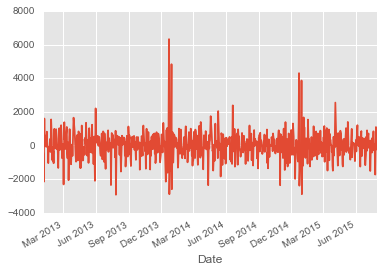

In [43]:
df[df.Open == 1].Sales.diff(1).plot()

They match.  Note that this is generally true, but the variance is NOT constant.

With our models, we can also plot our predictions against the true series using the plot_predict function: We can compare the last 50 days of true values against our predictions.

//anaconda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


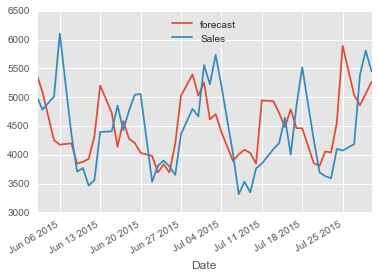

In [44]:
plot = model.plot_predict(1, 50)

The function takes two arguments, the start and end index of the dataframe to plot.  Here, we are plotting the last 50 values.  To plot earlier values with our predictions continuing where the true values stop, we can do the following.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
//anaconda/lib/python3.5/site-packages/statsmodels/tsa/arima_model.py:1847: FutureWarning: TimeSeries is deprecated. Please use Series
  forecast = TimeSeries(forecast, index=self.data.predict_dates)


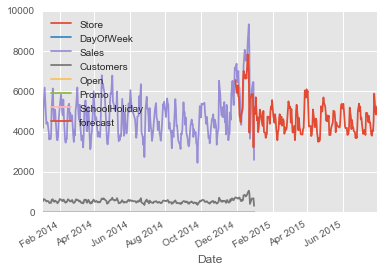

In [45]:
fig, ax = plt.subplots()
ax = df['2014'][df.Open == 1].plot(ax = ax)

fig = model.plot_predict(1, 200, ax = ax, plot_insample = False)

This plots true values in 2014 and our predictions 200 days out from 2014.

## Activity

We can revisit our diagnostics to check that our models are working well.

1. Plot the residuals and autocorrelation of the residuals.
1. Are there patterns or outliers?

Answer:

The two previous problems remain:
- Large seasonal errors
- Errors with high autocorrelation

We can adjust the AR component of the model to adjust for a piece of this.  Let's increase the lag to 7.

In [46]:
model = sm.tsa.arima_model.ARIMA(df[df.Open == 1].Sales, (7, 1, 2)).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(7, 1, 2)   Log Likelihood               -6221.636
Method:                       css-mle   S.D. of innovations            703.783
Date:                Tue, 28 Jun 2016   AIC                          12465.272
Time:                        20:05:27   BIC                          12516.524
Sample:                    07-30-2015   HQIC                         12484.984
                         - 01-02-2013                                         
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const             0.6862      4.555      0.151      0.880        -8.241     9.613
ar.L1.D.Sales     0.8404      0.211      3.982      0.000         0.427     1.254
ar.L2.D.Sales    -0.1503      0.145     -1.038      0.300        -0.434     0.134
ar.L3.D.Sales    -0.1831      0.046     -3.976      0.000        -0.273    -0.093
ar.L4.D.Sales     0.2557      0.060      4.296      0.000         0.139     0.372
ar.L5.D.Sales    -0.3381      0.067     -5.018      0.000        -0.470    -0.206
ar.L6.D.Sales     0.0691      0.074      0.931      0.352        -0.076     0.215
ar.L7.D.Sales    -0.0656      0.050     -1.325      0.185        -0.163     0.031
ma.L1.D.Sales    -1.1350      0.209     -5.443      0.000        -1.544    -0.726
ma.L2.D.Sales     0.2373      0.197      1.203      0.229        -0.149     0.624
                                    Roots                                    
=============================================================================
                 Real           Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2128           -0.0000j            1.2128           -0.5000
AR.2            1.0141           -0.4950j            1.1285           -0.0723
AR.3            1.0141           +0.4950j            1.1285            0.0723
AR.4           -0.1357           -1.7545j            1.7597           -0.2623
AR.5           -0.1357           +1.7545j            1.7597            0.2623
AR.6            0.2547           -1.7666j            1.7848           -0.2272
AR.7            0.2547           +1.7666j            1.7848            0.2272
MA.1            1.1647           +0.0000j            1.1647            0.0000
MA.2            3.6179           +0.0000j            3.6179            0.0000
-----------------------------------------------------------------------------
"""

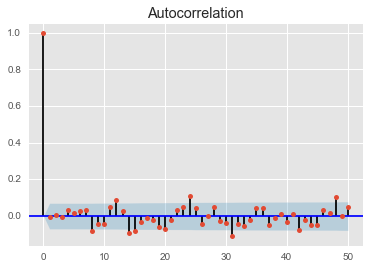

In [47]:
plot = plot_acf(model.resid, lags = 50)

This removes some of the autocorrelation in the residuals but large discrepancies still exist.

However, they exist where we are breaking our model assumptions.

## Activity

1. Alter the time period of predictions and the `p`, `d`, and `q` parameters
1. Do any of these improve diagnostics?
1. What does changing `p` and `q` imply based upon the autocorrelation plot?
1. How about changing `d`?

Answer:
    
- Increasing `p` increases the dependency on previous values further (longer lag).  But our autocorrelation plots show this isn’t necessary past a certain point.
- Increasing `q` increases the likelihood of an unexpected jump at a handful of points.  The autocorrelation plots show this doesn’t help past a certain point.
- Increasing `d` increases differencing, but `d = 1` moves our data towards stationarity (other than a few points).  `d = 2` would imply an exponential trend which we don’t have here.

There are variants of ARIMA that will better handle the seasonal aspect of our data.  This is referred to as Seasonal ARIMA.

These models fit two ARIMA models, one on the current frequency (daily in our example) and another on the seasonal frequency (maybe monthly or yearly patterns).

Additionally, issues with seasonality could be handled by preprocessing tricks such as detrending.